In [1]:
import os
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.data import Dataset

# Specify the height and width of the images.
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

# Specify the number of frames (images) in a sequence.
SEQUENCE_LENGTH = 15

# Specify the directories for training and testing data.
TRAIN_DIR = "/kaggle/input/ucf-crime-dataset/Train"
TEST_DIR = "/kaggle/input/ucf-crime-dataset/Test"

# List of class labels
CLASSES_LIST = ["Abuse", "Arson", "Arrest", "Explosion", "Fighting", "RoadAccidents", "Robbery", "Shooting"]

2025-05-02 15:18:07.343735: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746199087.569641      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746199087.643755      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:

# Enable mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Function to decode and preprocess images
def decode_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH])
    image = image / 255.0  # Normalize to [0, 1]
    return image

# Function to create dataset for training
def load_data_from_folder(directory):
    images = []
    labels = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        class_dir = os.path.join(directory, class_name)
        image_files = os.listdir(class_dir)
        image_files.sort()
        
        for image_file in image_files:
            image_path = os.path.join(class_dir, image_file)
            images.append(image_path)
            labels.append(class_index)

    return images, labels

# Load data from train and test directories
train_images, train_labels = load_data_from_folder(TRAIN_DIR)
test_images, test_labels = load_data_from_folder(TEST_DIR)

# Shuffle and split dataset into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42)

In [3]:
# Function to group images into sequences
def create_sequences(image_paths, labels, sequence_length=SEQUENCE_LENGTH):
    sequences = []
    sequence_labels = []
    
    for i in range(0, len(image_paths) - sequence_length + 1, sequence_length):
        sequence = image_paths[i:i + sequence_length]
        label = labels[i + sequence_length - 1]  # Use the last label of the sequence
        sequences.append(sequence)
        sequence_labels.append(label)

    return sequences, sequence_labels

# Create sequences for training and validation datasets
train_sequences, train_sequence_labels = create_sequences(train_images, train_labels)
val_sequences, val_sequence_labels = create_sequences(val_images, val_labels)

# One-hot encode the labels for training and validation
train_labels_one_hot = to_categorical(train_sequence_labels, num_classes=len(CLASSES_LIST))
val_labels_one_hot = to_categorical(val_sequence_labels, num_classes=len(CLASSES_LIST))

# Create tf.data.Dataset for train and validation
train_dataset = Dataset.from_tensor_slices((train_sequences, train_labels_one_hot))
val_dataset = Dataset.from_tensor_slices((val_sequences, val_labels_one_hot))

# Count the number of samples in the train dataset
train_count = sum(1 for _ in train_dataset)
print(f"Number of samples in the train dataset: {train_count}")

# Count the number of samples in the validation dataset
val_count = sum(1 for _ in val_dataset)
print(f"Number of samples in the validation dataset: {val_count}")

# Map function to decode and preprocess the images in sequences
def map_fn(sequence_paths, label):
    # Use TensorFlow map_fn to load and process multiple images in parallel
    sequence_images = tf.map_fn(lambda path: decode_image(path), sequence_paths, dtype=tf.float32)
    sequence_images = tf.stack(sequence_images)  # Stack the sequence of images
    return sequence_images, label

# Apply the map function to the dataset
train_dataset = train_dataset.map(map_fn).batch(16).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.map(map_fn).batch(16).prefetch(tf.data.experimental.AUTOTUNE)

I0000 00:00:1746199105.730742      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746199105.731433      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Number of samples in the train dataset: 9890
Number of samples in the validation dataset: 2472


In [4]:
# Create LRCN model with Attention mechanism
def create_LRCN_model_with_attention():
    model = Sequential()
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
                              input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    model.add(TimeDistributed(Flatten()))
    
    model.add(LSTM(32, return_sequences=True))  # Match the LSTM units with attention
    
    # Apply attention mechanism
    attention = Attention()([model.layers[-2].output, model.layers[-2].output])  # Use the same LSTM output for attention
    attended_out = Concatenate(axis=-1)([model.layers[-2].output, attention])
    
    model.add(LSTM(32, return_sequences=False))  # Match the LSTM units with attention
    
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))
    
    model.summary()
    
    return model

In [5]:
# Initialize and compile the model
LRCN_model_with_attention = create_LRCN_model_with_attention()
LRCN_model_with_attention.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 15, 64, 64, 16)      │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 15, 16, 16, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 15, 16, 16, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 15, 16, 16, 32)      │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 15, 4, 4, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 15, 4, 4, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 15, 4, 4, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 15, 2, 2, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 15, 2, 2, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 15, 2, 2, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, 15, 1, 1, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, 15, 64)              │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 15, 32)              │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 81,512 (318.41 KB)

 Trainable params: 81,512 (318.41 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Train the model with the checkpoint callback
LRCN_model_training_history = LRCN_model_with_attention.fit(
    train_dataset, 
    epochs=70,  # Training for 80 epochs
    validation_data=val_dataset  # Adding the checkpoint callback
)

# Save the final model (in case you want to save the last model too)
LRCN_model_with_attention.save("LSTM_with_attention_final1.h5")
print("Final model saved as LSTM_with_attention_final.h5")

# Evaluate the best model
model_evaluation_history = LRCN_model_with_attention.evaluate(val_dataset)


Epoch 1/70


I0000 00:00:1746199129.052674      62 cuda_dnn.cc:529] Loaded cuDNN version 90300


619/619 ━━━━━━━━━━━━━━━━━━━━ 384s 582ms/step - accuracy: 0.2200 - loss: 2.0134 - val_accuracy: 0.2217 - val_loss: 1.9997
Epoch 2/70
619/619 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.2899 - loss: 1.8690 - val_accuracy: 0.4373 - val_loss: 1.5494
Epoch 3/70
619/619 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.4288 - loss: 1.5526 - val_accuracy: 0.4984 - val_loss: 1.3984
Epoch 4/70
619/619 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - accuracy: 0.4972 - loss: 1.4107 - val_accuracy: 0.5999 - val_loss: 1.1849
Epoch 5/70
619/619 ━━━━━━━━━━━━━━━━━━━━ 47s 76ms/step - accuracy: 0.5719 - loss: 1.2175 - val_accuracy: 0.6837 - val_loss: 0.9782
Epoch 6/70
619/619 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.6533 - loss: 1.0227 - val_accuracy: 0.7419 - val_loss: 0.7926
Epoch 7/70
619/619 ━━━━━━━━━━━━━━━━━━━━ 46s 75ms/step - accuracy: 0.7194 - loss: 0.8653 - val_accuracy: 0.7994 - val_loss: 0.6569
Epoch 8/70
619/619 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.7549 - loss: 0.7511 - val_accur

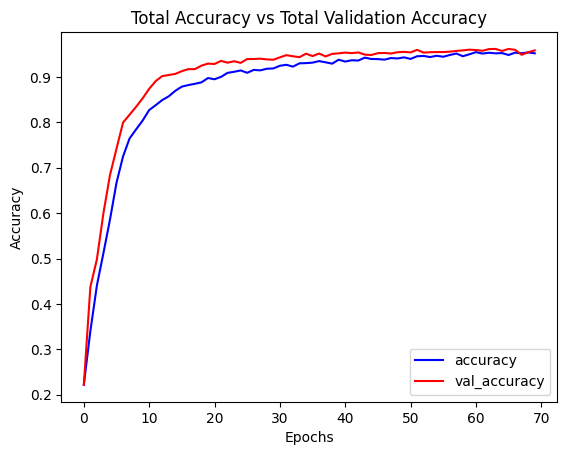

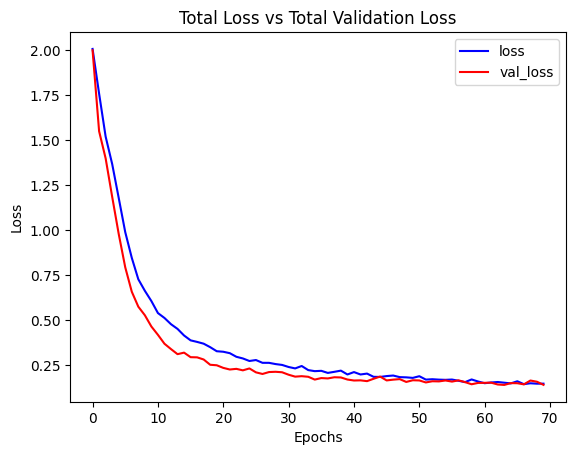

In [7]:

# Plot training metrics
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label=metric_name_2)
    plt.title(str(plot_name))
    plt.legend()

# Plot accuracy and validation accuracy metrics
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.savefig('ACCURACY1.PNG')
plt.show()

# Plot loss and validation loss metrics
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.savefig('Loss1.png')
plt.show()
